# Free energy landscape reconstruction from M-WEM data #

In this notebook we will reconstruct the free energy landscape of Alanine dipeptide along the $\Phi$ and $\Psi$ degrees of freedom from the M-WEM trajectory data. We need to load the ```trajectories.pkl``` and ```weights.txt``` files for each cell and the probability distribution in all cells from the ```cell_probability/cell_prob_100.dat``` (for the probability distribution after 100 iterations). The latter file is generated by the ```kinetics.ipynb``` notebook. **So, please run the** ```kinetics.ipynb``` **notebook before starting on this one**.

### Import necessary modules ###

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import scipy.interpolate

### Define a function to convert long list to array ###

In [2]:
#define function to convert long list to array
from itertools import chain
def longlist2array(longlist):
    flat = np.fromiter(chain.from_iterable(longlist), np.array(longlist[0][0]).dtype, -1) # Without intermediate list:)
    return flat.reshape((len(longlist), -1))

### Load the equilibrium probability distribution in all cells (obtained from M-WEM) ###

In [3]:
p = np.loadtxt('cell_probability/cell_prob_100.dat')
p

array([[-7.00000000e+01,  7.48312614e-01],
       [-5.00000000e+01,  1.03397717e-01],
       [-3.00000000e+01,  6.39904688e-03],
       [-1.00000000e+01,  1.27114095e-03],
       [ 1.00000000e+01,  1.00709843e-03],
       [ 3.00000000e+01,  5.10267731e-03],
       [ 5.00000000e+01,  3.64816084e-02],
       [ 7.00000000e+01,  9.80280973e-02]])

### Construct the probabilty distribution of trajectory data for all cells ###

* The trajectory data is read from the ```trajectories.pkl``` files (which contain the data after 100 iterations), for all M-WEM cells.
* The weights for all trajectory traces are read for each cell
* For each cell the trajectory data is reweighted by the weights of respective traces
* A histrogram is constructed for each individual cell with the reweighted data.

Note that these histograms are still **unscaled**, i.e. they are only reweighted based on the WE weights of each trace, but their probabilities are not rescaled by the probabilities of each cell obtained from milestoning analysis. This unscaled probability distribution can be expressed by 
$p^{\alpha}(\Phi,\Psi) = \sum_{J=1}^{M_{\alpha}} w_J p^{\alpha}_J(\Phi,\Psi)$,
where $p^{\alpha}_J(\Phi,\Psi)$ is the histogram of the $J$th trajectory in cell $\alpha$, $w_J$ is the WE weight of the $J$th trajectory and there are $M_{\alpha}$ traces in cell $\alpha$.

The approximate computational cost is also calculated by summing over the trajectory traces.

In [4]:

cost = 0.0
probabilities = []
xedges = np.linspace(-175.0, 175.0, num=140)
for i in range(len(p)):
    a = pickle.load(open('cell_%d/trajectories.pkl'%i,'rb'))

    w = np.loadtxt('cell_%d/weights.txt'%i)

    N_traj = len(w)
    len_traj = len(a[0])


    weights_array = np.repeat(w,len_traj)
    

    #patch all trajectories one after another
    trajs_stacked = [j for k in a for j in k]
    
    trajs_stacked = longlist2array(trajs_stacked)
    
    cost += len(trajs_stacked)*1E-5
    
    histogm, xx, yy, img = plt.hist2d(trajs_stacked[:,0],trajs_stacked[:,1],bins=xedges,
                                      density=True,weights=weights_array);
    probabilities.append(histogm.transpose())
    plt.close() #we don't want to plot a figure here

print("computational cost = ",cost,"ns")

computational cost =  86.39999999999999 ns


### Unscaled probability distribution ###

Construct the unscaled probability distribution by summing over the histograms for all cell: $p^{unscaled}(\Phi,\Psi) = \sum_{\alpha} p^{\alpha}(\Phi,\Psi)$

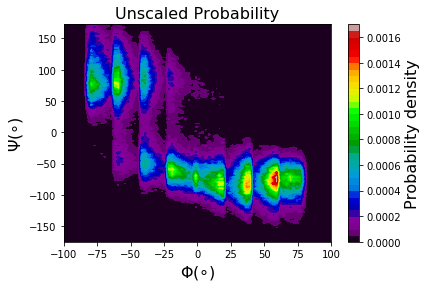

In [5]:
x = xedges
x = np.delete(x,-1)
y = xedges
y = np.delete(y,-1)

probs_unscaled = np.zeros((len(x),len(y)))
for i in range(len(probabilities)):
    probs_unscaled += probabilities[i]
fig = plt.figure()
cp = plt.contourf(x,y,probs_unscaled, 40, cmap='nipy_spectral')
cbar = plt.colorbar(cp)
cbar.set_label('Probability density',fontsize=16)
plt.xlim(-100,100)
plt.ylabel("$\Psi (\circ)$",fontsize=16)
plt.xlabel("$\Phi (\circ)$",fontsize=16)
plt.title("Unscaled Probability",fontsize=16)
plt.show()

### Rescaled probability distribution ###

Construct the rescaled probability distribution by summing over the histograms for all cells with appropriate weights (the probability of each cell $\pi_{\alpha}$): $p(\Phi,\Psi) = \sum_{\alpha} \pi_{\alpha} p^{\alpha}(\Phi,\Psi)$

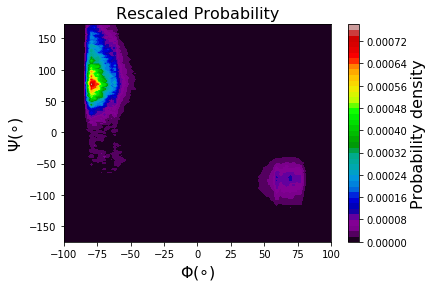

In [6]:
x = xedges
x = np.delete(x,-1)
y = xedges
y = np.delete(y,-1)

probs = np.zeros((len(x),len(y)))
for i in range(len(probabilities)):
    #probablity distributions are rescaled via multiplying by the cell probabilities 
    probs += p[i,1]*probabilities[i]
fig = plt.figure()
cp = plt.contourf(x,y,probs, 40, cmap='nipy_spectral')
cbar = plt.colorbar(cp)
cbar.set_label('Probability density',fontsize=16)
plt.xlim(-100,100)
plt.ylabel("$\Psi (\circ)$",fontsize=16)
plt.xlabel("$\Phi (\circ)$",fontsize=16)
plt.title("Rescaled Probability",fontsize=16)
plt.show()

### Free energy landscape from the unscaled probabilty distribution ###

$G^{unscaled}(\Phi,\Psi)  = -k_BT \ln \left(\sum^{\Lambda}_{\alpha=1} p^{\alpha}(\Phi,\Psi)\right)$

/home/dhiman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


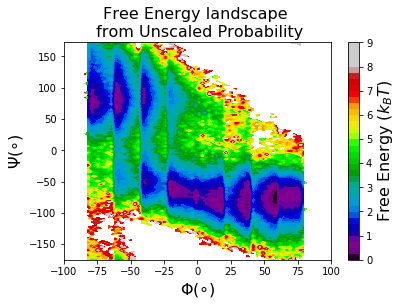

In [7]:
free_energy_unscaled = -np.log(probs_unscaled)
free_energy_unscaled -= np.min(free_energy_unscaled)

#----------- Ignoring very high free energy values --------------#
for i in range(len(free_energy_unscaled)):
    for j in range(len(free_energy_unscaled[i])):
        if free_energy_unscaled[i,j] >= 9.0:
            free_energy_unscaled[i,j] = np.inf
#----------------------------------------------------------------#
            
fig = plt.figure()
cp = plt.contourf(x,y,free_energy_unscaled, 40, cmap='nipy_spectral')
plt.xlim(-100,100)
plt.clim(0.0,8)
cbar = plt.colorbar(cp)
cbar.set_label('Free Energy ($k_BT$)',fontsize=16)

plt.ylabel("$\Psi (\circ)$",fontsize=16)
plt.xlabel("$\Phi (\circ)$",fontsize=16)
plt.title("Free Energy landscape \n from Unscaled Probability",fontsize=16)
plt.show()

### Free energy landscape from the rescaled probabilty distribution ###

$G(\Phi,\Psi)  = -k_BT \ln \left(\sum^{\Lambda}_{\alpha=1} \pi_{\alpha} p^{\alpha}(\Phi,\Psi)\right)$

/home/dhiman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


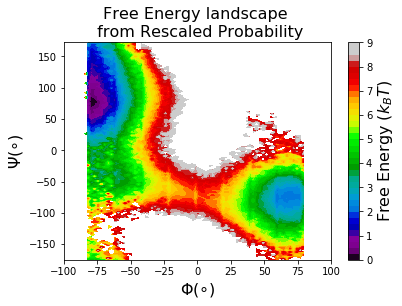

In [9]:
free_energy = -np.log(probs)
free_energy -= np.min(free_energy)

#----------- Ignoring very high free energy values --------------#
for i in range(len(free_energy)):
    for j in range(len(free_energy[i])):
        if free_energy[i,j] >= 9.0:
            free_energy[i,j] = np.inf
#----------------------------------------------------------------#

fig = plt.figure()
cp = plt.contourf(x,y,free_energy, 40, cmap='nipy_spectral')
plt.xlim(-100,100)
plt.clim(0.0,8.5)
cbar = plt.colorbar(cp)
cbar.set_label('Free Energy ($k_BT$)',fontsize=16)

plt.ylabel("$\Psi (\circ)$",fontsize=16)
plt.xlabel("$\Phi (\circ)$",fontsize=16)
plt.title("Free Energy landscape \n from Rescaled Probability",fontsize=16)
plt.show()
#plt.savefig('freeE.png',dpi=200,bbox_inches='tight')

### Reference ###

1.  "Markovian Weighted Ensemble Milestoning (M-WEM): Long-time Kinetics from Short Trajectories" Dhiman Ray, Sharon E. Stone, Ioan Andricioaei, BioRxiv, doi: https://doi.org/10.1101/2021.06.26.450057